In [1]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import math
import os
# Tilt compensation need accelerometer to calculate the angle
from scipy.signal import butter, filtfilt


def read_file(filename):
    try:
        t, x, y, z = np.loadtxt(filename, delimiter=';', skiprows=1, unpack=True)
        t = t - t[0]
        return t, x, y, z
    except:
        print("Error loading file")
        sys.exit()

#######################################################################################
def data_detect(folder_dir):
    for file in os.listdir(folder_dir):
        if file == 'accelerometer.csv':
            acc_path = os.path.join(folder_dir, file)
        elif file == 'magnetometer.csv':
            mag_path = os.path.join(folder_dir, file)
        elif file == 'gyroscope.csv':
            gyro_path = os.path.join(folder_dir, file)
    return acc_path, mag_path, gyro_path
#######################################################################################
def data_detect_v2(folder_dir):
    for file in os.listdir(folder_dir):
        if file == 'new_accelerometer.csv':
            acc_path = os.path.join(folder_dir, file)
        elif file == 'new_magnetometer.csv':
            mag_path = os.path.join(folder_dir, file)
        elif file == 'gyroscope.csv':
            gyro_path = os.path.join(folder_dir, file)
    return acc_path, mag_path, gyro_path
######################################################################################
def diff_cal(ref_sensor_time, ref_index, new_sensor_time, new_index):
    return abs(ref_sensor_time[ref_index] - new_sensor_time[new_index])

#######################################################################################

def data_matching(ref_sensor, new_sensor, new_sensor_output):
    #Match data between 2 table with the least latency
    ref_t, ref_x, ref_y, ref_z = read_file(ref_sensor)
    new_t, new_x, new_y, new_z = read_file(new_sensor)
    f = open(new_sensor_output, 'a+')
    f.truncate(0)
    f.write(r"timestamp;x (in G's);y (in G's);z (in G's)" + '\n')
    # ref_sensor_time = ref_sensor_data[0]
    # new_sensor_time = new_sensor_data[0]
    ref_index, anchor = 0, 0
    while True:
        # tmp = 0
        # diff = math.abs(ref_sensor_time[ref_index] - new_sensor_time[anchor])
        diff = diff_cal(ref_t, ref_index, new_t, anchor)
        # tmp_index = anchor + 1
        tmp_index = 1
        while True:
            if anchor + tmp_index >= len(new_t):
                break
            tmp_diff = diff_cal(ref_t, ref_index, new_t, anchor + tmp_index)
            if tmp_diff >= diff:
                break
            else:
                diff = tmp_diff
                tmp_index += 1
        anchor = anchor + tmp_index - 1
        f.write(str(new_t[anchor]) + ';' + str(new_x[anchor]) + ';' + str(new_y[anchor]) + ';' + str(
            new_z[anchor]) + '\n')
        # f.write(str(new_t[tmp_index]) + ';' + str(new_x[tmp_index]) + ';' + str(new_y[tmp_index]) + ';' + str(new_z[tmp_index]) + '\n')
        ref_index += 1
        anchor += 1
        if ref_index >= len(ref_t):
            break
        if anchor >= len(new_t):
            break
    f.close()
    
    
####################################################################################
def convert_unit(mag_x, mag_y, mag_z):
    # Use for convert from Tesla to Gauss
    return 10*mag_x, 10*mag_y, 10*mag_z

#######################################################################################
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
#######################################################################################

def butter_lowpass_filter(data, cutoff=6.0, fs=100.0, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y

#########################################################################################

def tilt_compensation(mag_x, mag_y, mag_z, acc_x, acc_y):
    acc_x = normalization(mag_x, acc_x)
    acc_y = normalization(mag_y, acc_y)
    tmp = np.sqrt(1 - np.square(acc_x) - np.square(acc_y))
    compensated_x = mag_x * (1 - np.square(acc_x)) - mag_y * acc_x * acc_y - mag_z * acc_x * tmp
    compensated_y = mag_y * tmp - mag_z * acc_y
    return compensated_x, compensated_y

#######################################################################################
def tilt_compensation_v2(mag_x, mag_y, mag_z, pitch, roll):
    X_h = mag_x * np.cos(pitch) + mag_y * np.sin(roll) * np.sin(pitch) + mag_z * np.cos(roll) * np.sin(pitch)
    Y_h = mag_y * np.cos(roll) - mag_z * np.sin(roll)
    return X_h, Y_h

#######################################################################################
def tilt_angle(mag_x, acc_x, acc_y, acc_z):
    norm_acc_x = normalization(mag_x, acc_x)
    norm_acc_y = normalization(mag_x, acc_y)
    norm_acc_z = normalization(mag_x, acc_z)
    pitch = np.arctan2(-norm_acc_x, np.sqrt(norm_acc_z * norm_acc_z + norm_acc_y * norm_acc_y))
    roll = np.arctan2(norm_acc_y, np.sqrt(norm_acc_z * norm_acc_z + norm_acc_x * norm_acc_x))

    # pitch = np.arcsin(acc_y, 9.8)
    return pitch, roll
#######################################################################################
def hard_iron(mag_x, mag_y, mag_z):
    offset_x = (max(mag_x) + min(mag_x)) / 2
    offset_y = (max(mag_y) + min(mag_y)) / 2
    offset_z = (max(mag_z) + min(mag_z)) / 2
    return offset_x, offset_y, offset_z

#######################################################################################
# Change to do calculation with numpy
def soft_iron(mag_x, mag_y, mag_z):
    offset_x, offset_y, offset_z = hard_iron(mag_x, mag_y, mag_z)
    avg_delta_x = (max(mag_x) - min(mag_x)) / 2
    avg_delta_y = (max(mag_y) - min(mag_y)) / 2
    avg_delta_z = (max(mag_z) - min(mag_z)) / 2
    avg_delta = (avg_delta_x + avg_delta_y + avg_delta_z) / 3

    scale_x = avg_delta / avg_delta_x
    scale_y = avg_delta / avg_delta_y
    scale_z = avg_delta / avg_delta_z

    corrected_x = (mag_x - offset_x) * scale_x
    corrected_y = (mag_y - offset_y) * scale_y
    corrected_z = (mag_z - offset_z) * scale_z
    return corrected_x, corrected_y, corrected_z

#######################################################################################
def angle_evaluation(corrected_x, corrected_y):
    # angle = 90 - np.arctan2(corrected_y, corrected_x) * 180 / np.pi
    angle = np.arctan2(corrected_x, corrected_y) * 180 / np.pi
#   angle = (angle + 360) % 360
    # angle = np.arctan2(corrected_y, corrected_x) * 180 / np.pi
    return angle

#######################################################################################
def angle_evaluation_360(corrected_x, corrected_y):
    angle = np.arctan2(corrected_x, corrected_y) * 180 / np.pi
    angle = (angle + 360) % 360
    # angle = np.arctan2(corrected_y, corrected_x) * 180 / np.pi
    return angle

#######################################################################################
def angle_evaluation_v2(corrected_x, corrected_y):
    angles = []
    # for index, x in enumerate(corrected_x):
    #     if math.atan2(corrected_y[index], x) >= 0:
    #         angles.append(math.atan2(corrected_y[index], x) * (180 / math.pi))
    #     else:
    #         angles.append((math.atan2(corrected_y[index], x) + 2 * math.pi) * (180 / math.pi))
    for index, x in enumerate(corrected_x):
        if math.atan2(corrected_y[index], x) >= 0:
            angles.append(math.atan2(x, corrected_y[index]) * (180 / math.pi))
        else:
            angles.append((math.atan2(x, corrected_y[index]) + 2 * math.pi) * (180 / math.pi))

    return angles

#######################################################################################
def absolute_angle(angles):
    previous = 0
    abs_angle = np.zeros(shape=(len(angles), 1))
    for index, angle in enumerate(angles):
        if index == 0:
            abs_angle[index] = 0
            previous = angle
        else:
            abs_angle[index] = angle - previous
            previous = angle

    return abs_angle

#######################################################################################
#Create data for Madgwick algorithm
def create_data(sensor_x, sensor_y, sensor_z):
    output = []
    for index, val in enumerate(sensor_x):
        output.append([val, sensor_y[index], sensor_z[index]])
    return output
#################################################################################################
######################################TEST MODULE###########################################
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-9-2020\accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-9-2020\magnetometer.csv'
# new_acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-9-2020\new_acc.csv'
# sensor_fusion(mag_path, acc_path, new_acc_path)
# sensor_fusion(mag_path, acc_path, new_acc_path)
# def main():
#     uncalib_data_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\18-9-2020\magnetometer.csv'
#     accelerometer_data_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\18-9-2020\accelerometer.csv'
#     acc_time, acc_x, acc_y, acc_z = read_file(accelerometer_data_path)
#     mag_time, mag_x, mag_y, mag_z = read_file(uncalib_data_path)
#
#
#
# if __name__ == '__main__':
#     main()



In [2]:
# -*- coding: utf-8 -*-
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import numbers

import numpy as np


class Quaternion:
    """
    A simple class implementing basic quaternion arithmetic.
    """
    def __init__(self, w_or_q, x=None, y=None, z=None):
        """
        Initializes a Quaternion object
        :param w_or_q: A scalar representing the real part of the quaternion, another Quaternion object or a
                    four-element array containing the quaternion values
        :param x: The first imaginary part if w_or_q is a scalar
        :param y: The second imaginary part if w_or_q is a scalar
        :param z: The third imaginary part if w_or_q is a scalar
        """
        self._q = np.array([1, 0, 0, 0])

        if x is not None and y is not None and z is not None:
            w = w_or_q
            q = np.array([w, x, y, z])
        elif isinstance(w_or_q, Quaternion):
            q = np.array(w_or_q.q)
        else:
            q = np.array(w_or_q)
            if len(q) != 4:
                raise ValueError("Expecting a 4-element array or w x y z as parameters")

        self._set_q(q)

    # Quaternion specific interfaces

    def conj(self):
        """
        Returns the conjugate of the quaternion
        :rtype : Quaternion
        :return: the conjugate of the quaternion
        """
        return Quaternion(self._q[0], -self._q[1], -self._q[2], -self._q[3])

    def to_angle_axis(self):
        """
        Returns the quaternion's rotation represented by an Euler angle and axis.
        If the quaternion is the identity quaternion (1, 0, 0, 0), a rotation along the x axis with angle 0 is returned.
        :return: rad, x, y, z
        """
        if self[0] == 1 and self[1] == 0 and self[2] == 0 and self[3] == 0:
            return 0, 1, 0, 0
        rad = np.arccos(self[0]) * 2
        imaginary_factor = np.sin(rad / 2)
        if abs(imaginary_factor) < 1e-8:
            return 0, 1, 0, 0
        x = self._q[1] / imaginary_factor
        y = self._q[2] / imaginary_factor
        z = self._q[3] / imaginary_factor
        return rad, x, y, z

    @staticmethod
    def from_angle_axis(rad, x, y, z):
        s = np.sin(rad / 2)
        return Quaternion(np.cos(rad / 2), x*s, y*s, z*s)

    def to_euler_angles(self):
        pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
        if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
            roll = 0
            yaw = 2 * np.arctan2(self[1], self[0])
        elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
            roll = -2 * np.arctan2(self[1], self[0])
            yaw = 0
        else:
            roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
            yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
        return roll, pitch, yaw

    def to_euler123(self):
        roll = np.arctan2(-2*(self[2]*self[3] - self[0]*self[1]), self[0]**2 - self[1]**2 - self[2]**2 + self[3]**2)
        pitch = np.arcsin(2*(self[1]*self[3] + self[0]*self[1]))
        yaw = np.arctan2(-2*(self[1]*self[2] - self[0]*self[3]), self[0]**2 + self[1]**2 - self[2]**2 - self[3]**2)
        return roll, pitch, yaw

    def __mul__(self, other):
        """
        multiply the given quaternion with another quaternion or a scalar
        :param other: a Quaternion object or a number
        :return:
        """
        if isinstance(other, Quaternion):
            w = self._q[0]*other._q[0] - self._q[1]*other._q[1] - self._q[2]*other._q[2] - self._q[3]*other._q[3]
            x = self._q[0]*other._q[1] + self._q[1]*other._q[0] + self._q[2]*other._q[3] - self._q[3]*other._q[2]
            y = self._q[0]*other._q[2] - self._q[1]*other._q[3] + self._q[2]*other._q[0] + self._q[3]*other._q[1]
            z = self._q[0]*other._q[3] + self._q[1]*other._q[2] - self._q[2]*other._q[1] + self._q[3]*other._q[0]

            return Quaternion(w, x, y, z)
        elif isinstance(other, numbers.Number):
            q = self._q * other
            return Quaternion(q)

    def __add__(self, other):
        """
        add two quaternions element-wise or add a scalar to each element of the quaternion
        :param other:
        :return:
        """
        if not isinstance(other, Quaternion):
            if len(other) != 4:
                raise TypeError("Quaternions must be added to other quaternions or a 4-element array")
            q = self.q + other
        else:
            q = self.q + other.q

        return Quaternion(q)

    # Implementing other interfaces to ease working with the class

    def _set_q(self, q):
        self._q = q

    def _get_q(self):
        return self._q

    q = property(_get_q, _set_q)

    def __getitem__(self, item):
        return self._q[item]

    def __array__(self):
        return self._q



In [3]:
# -*- coding: utf-8 -*-
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import warnings

import numpy as np
from numpy.linalg import norm

# from .quaternion import Quaternion


class MadgwickAHRS:
    samplePeriod = 1/256
    quaternion = Quaternion(1, 0, 0, 0)
    beta = 1

    def __init__(self, sampleperiod=None, quaternion=None, beta=None):
        """
        Initialize the class with the given parameters.
        :param sampleperiod: The sample period
        :param quaternion: Initial quaternion
        :param beta: Algorithm gain beta
        :return:
        """
        if sampleperiod is not None:
            self.samplePeriod = sampleperiod
        if quaternion is not None:
            self.quaternion = quaternion
        if beta is not None:
            self.beta = beta

    def update(self, gyroscope, accelerometer, magnetometer):
        """
        Perform one update step with data from a AHRS sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        :param magnetometer: A three-element array containing the magnetometer data. Can be any unit since a normalized value is used.
        :return:
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()
        magnetometer = np.array(magnetometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Normalise magnetometer measurement
        if norm(magnetometer) is 0:
            warnings.warn("magnetometer is zero")
            return
        magnetometer /= norm(magnetometer)

        h = q * (Quaternion(0, magnetometer[0], magnetometer[1], magnetometer[2]) * q.conj())
        # b = np.array([0, norm(h[1:3]), 0, h[3]])

        #Experimenting
        b = np.array([0, 0, norm(h[1:3]), h[3]])

        # Gradient descent algorithm corrective step
        # f = np.array([
        #     2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
        #     2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
        #     2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2],
        #     2*b[1]*(0.5 - q[2]**2 - q[3]**2) + 2*b[3]*(q[1]*q[3] - q[0]*q[2]) - magnetometer[0],
        #     2*b[1]*(q[1]*q[2] - q[0]*q[3]) + 2*b[3]*(q[0]*q[1] + q[2]*q[3]) - magnetometer[1],
        #     2*b[1]*(q[0]*q[2] + q[1]*q[3]) + 2*b[3]*(0.5 - q[1]**2 - q[2]**2) - magnetometer[2]
        # ])

        #Experimenting
        f = np.array([
            2 * (q[1] * q[3] - q[0] * q[2]) - accelerometer[0],
            2 * (q[0] * q[1] + q[2] * q[3]) - accelerometer[1],
            2 * (0.5 - q[1] ** 2 - q[2] ** 2) - accelerometer[2],
            2 * b[1] * (0.5 - q[2] ** 2 - q[3] ** 2) + 2 * b[2] * (q[0] * q[3] + q[1] * q[2]) + 2 * b[3] * (q[1] * q[3] - q[0] * q[2]) - magnetometer[0],
            2 * b[1] * (q[1] * q[2] - q[0] * q[3]) + 2 * b[2] * (0.5 - q[1] ** 2 - q[3] ** 2) + 2 * b[3] * (q[0] * q[1] + q[2] * q[3]) - magnetometer[1],
            2 * b[1] * (q[0] * q[2] + q[1] * q[3]) + 2 * b[2] * (q[2] * q[3] - q[0] * q[1]) + 2 * b[3] * (0.5 - q[1] ** 2 - q[2] ** 2) - magnetometer[2]
        ])

        #
        # j = np.array([
        #     [-2*q[2],                  2*q[3],                  -2*q[0],                  2*q[1]],
        #     [2*q[1],                   2*q[0],                  2*q[3],                   2*q[2]],
        #     [0,                        -4*q[1],                 -4*q[2],                  0],
        #     [-2*b[3]*q[2],             2*b[3]*q[3],             -4*b[1]*q[2]-2*b[3]*q[0], -4*b[1]*q[3]+2*b[3]*q[1]],
        #     [-2*b[1]*q[3]+2*b[3]*q[1], 2*b[1]*q[2]+2*b[3]*q[0], 2*b[1]*q[1]+2*b[3]*q[3],  -2*b[1]*q[0]+2*b[3]*q[2]],
        #     [2*b[1]*q[2],              2*b[1]*q[3]-4*b[3]*q[1], 2*b[1]*q[0]-4*b[3]*q[2],  2*b[1]*q[1]]
        # ])

        #Experimenting
        j = np.array([
            [-2 * q[2],                2 * q[3],                -2 * q[0],                2 * q[1]],
            [2 * q[1],                 2 * q[0],                 2 * q[3],                2 * q[2]],
            [0,                        -4 * q[1],                -4 * q[2],                      0],
            [2 * b[2] * q[3] - 2 * b[3] * q[2],
             2 * b[2] * q[2] + 2 * b[3] * q[3],
             -4 * b[1] * q[2] + 2 * b[2] * q[1] - 2 * b[3] * q[0],
             -4 * b[1] * q[3] + 2 * b[2] * q[0] + 2 * b[3] * q[1]],

            [- 2 * b[1] * q[3] + 2 * b[3] * q[1],
             2 * b[1] * q[2] - 4 * b[2] * q[1] + 2 * b[3] * q[0],
             2 * b[1] * q[1] + 2 * b[3] * q[3],
             -2 * b[1] * q[0] - 4 * b[2] * q[3] + 2 * b[3] * q[2]],

            [2 * b[1] * q[2] - 2 * b[2] * q[1],
             2 * b[1] * q[3] - 2 * b[2] * q[0] - 4 * b[3] * q[1],
             2 * b[1] * q[0] + 2 * b[2] * q[3] - 4 * b[3] * q[2],
             2 * b[1] * q[1] + 2 * b[2] * q[2]]

        ])


        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

    def update_imu(self, gyroscope, accelerometer):
        """
        Perform one update step with data from a IMU sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2]
        ])
        j = np.array([
            [-2*q[2], 2*q[3], -2*q[0], 2*q[1]],
            [2*q[1], 2*q[0], 2*q[3], 2*q[2]],
            [0, -4*q[1], -4*q[2], 0]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion


In [6]:
#########################################################################
########################## Match sensor data ############################
#########################################################################
#Outdoor data
# acc_path = r'G:\PycharmProject\Magnetometer\MotionLoggerData\9-10-2020\accelerometer.csv'
# gyro_path = r'G:\PycharmProject\Magnetometer\MotionLoggerData\9-10-2020\gyroscope.csv'
# mag_path = r'G:\PycharmProject\Magnetometer\MotionLoggerData\9-10-2020\magnetometer.csv'
# #10-10-2020 Outdoor data
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor\accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor\magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor\gyroscope.csv'

# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\gyroscope.csv'

# acc_path, mag_path, gyro_path = data_detect(r'G:\PycharmProjects\Magnetometer\MotionLoggerData\14-10-2020')

acc_path, mag_path, gyro_path = data_detect(r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-10-2020-Outdoor')

# Because gyro has the least amount of data, we fuse according to it
# new_mag_ouput = r'G:\PycharmProject\Magnetometer\MotionLoggerData\9-10-2020\new_magnetometer.csv'
# new_acc_output = r'G:\PycharmProject\Magnetometer\MotionLoggerData\9-10-2020\new_accelerometer.csv'
#10-10-2020 Indoor
# new_mag_ouput = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020\new_magnetometer.csv'
# new_acc_output = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020\new_accelerometer.csv'

#10-10-2020 Outdoor
new_mag_ouput = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-10-2020-Outdoor\new_magnetometer.csv'
new_acc_output = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-10-2020-Outdoor\new_accelerometer.csv'
mag_t, mag_x, mag_y, mag_z = read_file(new_mag_ouput)
acc_t, acc_x, acc_y, acc_z = read_file(new_acc_output)
gyro_t, gyro_x, gyro_y, gyro_z = read_file(gyro_path)

# Match data using reference as gyroscope data
data_matching(gyro_path, mag_path, new_mag_ouput)
data_matching(gyro_path, acc_path, new_acc_output)


In [ ]:
#########################################################################
########################## Data visualization ###########################
#########################################################################
#10-10-2020 Indoor
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020\new_accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020\new_magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020\gyroscope.csv'
#10-10-2020 Outdoor
import matplotlib.pyplot as plt
acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\new_accelerometer.csv'
mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\new_magnetometer.csv'
gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\gyroscope.csv'

mag_t, mag_x, mag_y, mag_z = read_file(mag_path)
acc_t, acc_x, acc_y, acc_z = read_file(acc_path)
gyro_t, gyro_x, gyro_y, gyro_z = read_file(gyro_path)


plt.rcParams['figure.figsize'] = 15, 10
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(mag_x, label = 'x')
axs[0, 0].set_title('mag_x')
axs[0, 1].plot(mag_y)
axs[0, 1].set_title('mag_y')
axs[0, 2].plot(mag_z)
axs[0, 2].set_title('mag_z')
axs[1, 0].plot(acc_x)
axs[1, 0].set_title('acc_x')
axs[1, 1].plot(acc_y)
axs[1, 1].set_title('acc_y')
axs[1, 2].plot(acc_z)
axs[1, 2].set_title('acc_z')
axs[2, 0].plot(gyro_x)
axs[2, 0].set_title('gyro_x')
axs[2, 1].plot(gyro_y)
axs[2, 1].set_title('gyro_y')
axs[2, 2].plot(gyro_z)
axs[2, 2].set_title('gyro_z')

In [ ]:
#########################################################################
########################## Data correlation #############################
#########################################################################


plt.rcParams['figure.figsize'] = 15, 10
plt.plot(mag_x, label = 'x')
plt.plot(mag_y, label = 'y')
plt.plot(mag_z, label = 'z')
plt.legend(prop = {'size':15})

Text(0.5, 1.0, 'With iron compensation')

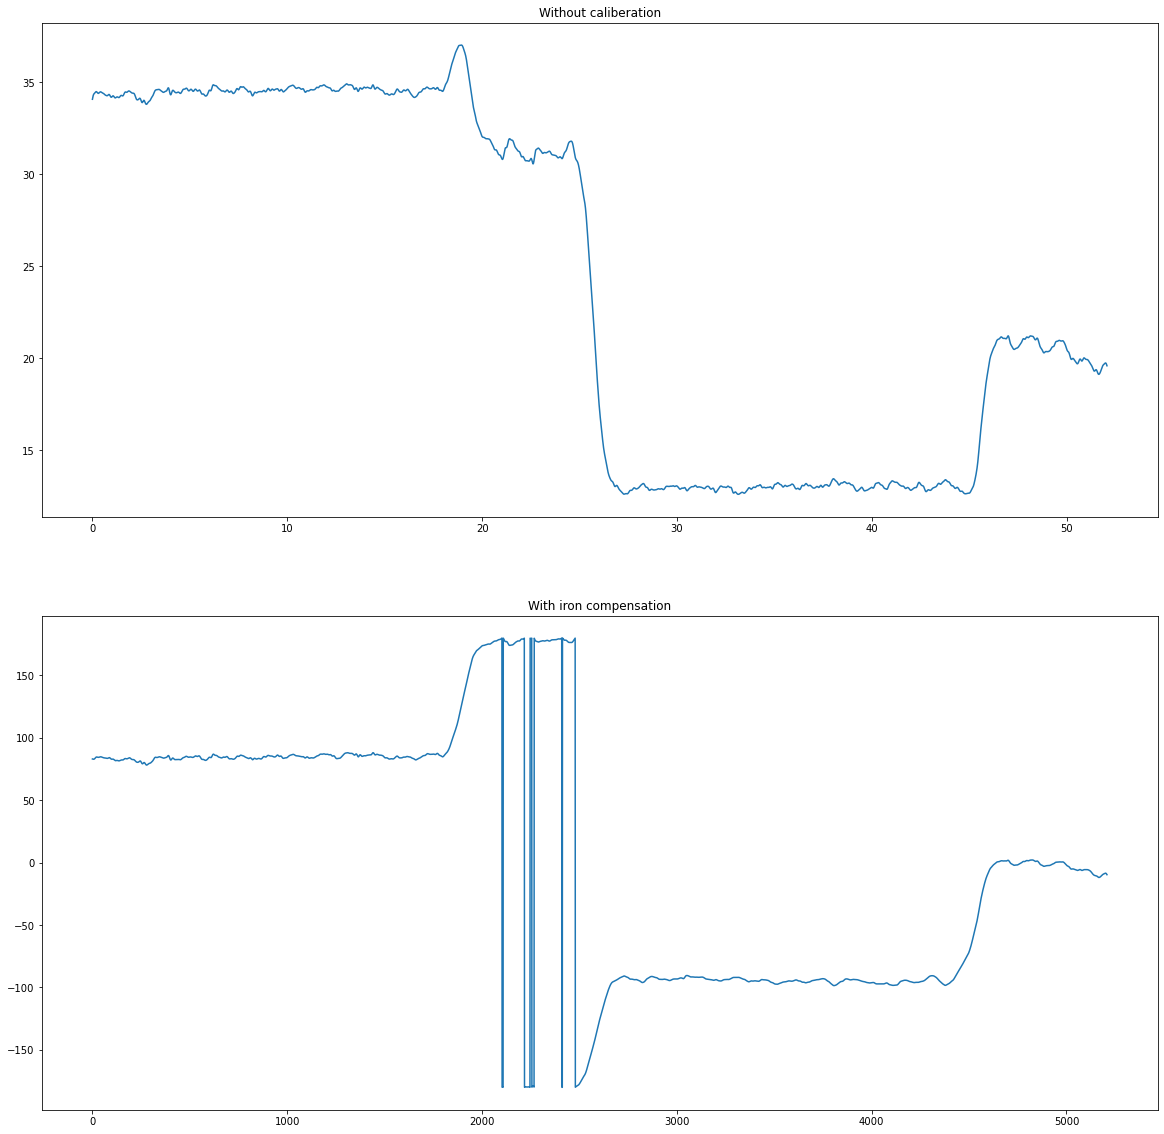

In [7]:
import matplotlib.pyplot as plt
import math
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\2-10-2020\magnetometer.csv'
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\cuong\accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\29-9-2020\magnetometer.csv'

# 9-10-2020 Outdoor data
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\9-10-2020\new_accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\9-10-2020\new_magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\9-10-2020\gyroscope.csv'

#Indoor data
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\new_accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\new_magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\gyroscope.csv'

#10-10-2020 Outdoor data
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor\new_accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor\new_magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor\gyroscope.csv'
# acc_path, mag_path, gyro_path = data_detect_v2(r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_Outdoor')

acc_path, mag_path, gyro_path = data_detect_v2(r'G:\PycharmProjects\Magnetometer\MotionLoggerData\20-10-2020-Outdoor')

#10-10-2020 test
# acc_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_test\new_accelerometer.csv'
# mag_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_test\new_magnetometer.csv'
# gyro_path = r'G:\PycharmProjects\Magnetometer\MotionLoggerData\10-10-2020_test\gyroscope.csv'

#Read file and apply low pass filter
mag_t, mag_x, mag_y, mag_z = read_file(mag_path)
mag_x, mag_y, mag_z = convert_unit(mag_x, mag_y, mag_z)
lp_mag_x, lp_mag_y, lp_mag_z = butter_lowpass_filter(mag_x), butter_lowpass_filter(mag_y), butter_lowpass_filter(mag_z)

acc_t, acc_x, acc_y, acc_z = read_file(acc_path)
acc_x, acc_y, acc_z = convert_unit(acc_x, acc_y, acc_z)
lp_acc_x, lp_acc_y, lp_acc_z = butter_lowpass_filter(acc_x), butter_lowpass_filter(acc_y), butter_lowpass_filter(acc_z)

gyro_t, gyro_x, gyro_y, gyro_z = read_file(gyro_path)
lp_gyro_x, lp_gyro_y, lp_gyro_z = butter_lowpass_filter(gyro_x), butter_lowpass_filter(gyro_y), butter_lowpass_filter(gyro_z)

# Angle with tilt compensation, soft iron and hard iron caliberation
# pitches, rolls = tilt_angle(mag_x, acc_x, acc_y, acc_z)
# compensated_x, compensated_y = tilt_compensation(mag_x, mag_y, mag_z, pitches, rolls)
# corrected_x, corrected_y, corrected_z = soft_iron(compensated_x, compensated_y, mag_z)
# calib_angles = angle_evaluation_v2(corrected_x, corrected_y)
# calib_abs_angle = absolute_angle(calib_angles)

#Without iron
# no_iron_angles = angle_evaluation_v2(compensated_x, compensated_y)

#Without tilt compensation
iron_compensated_x, iron_compensated_y, iron_compensated_z = soft_iron(lp_mag_x, lp_mag_y, lp_mag_z)
# iron_compensated_x, iron_compensated_y, iron_compensated_z = soft_iron(mag_x, mag_y, mag_z)
# iron_compensated_x, iron_compensated_y, iron_compensated_z = butter_lowpass_filter(iron_compensated_x), butter_lowpass_filter(iron_compensated_y), butter_lowpass_filter(iron_compensated_z)
iron_compensated_angles = angle_evaluation(iron_compensated_x, iron_compensated_y)
# iron_compensated_angles = iron_compensated_angles - iron_compensated_angles[0]
iron_compensated_abs_angles = absolute_angle(iron_compensated_angles)
iron_compensated_angles_360 = angle_evaluation_360(iron_compensated_x, iron_compensated_y)
# iron_compensated_angles_360 = iron_compensated_angles_360 - iron_compensated_angles_360[0]

#Without caliberation
uncalib_angles = angle_evaluation(lp_mag_x, lp_mag_y)
uncalib_abs_angles = absolute_angle(uncalib_angles)


plt.rcParams['figure.figsize'] = 20, 20
fig, axs = plt.subplots(2, 1)
axs[0].plot(gyro_t, uncalib_angles)
axs[0].set_title('Without caliberation')
axs[1].plot(iron_compensated_angles)
axs[1].set_title('With iron compensation')
# axs[2].plot(gyro_t, iron_compensated_angles_360)
# axs[2].set_title('With iron compensation - 360 degree ver')

# axs[1, 0] = fig.add_subplot(111, projection='3d')
# axs[1, 0].scatter(mag_x, mag_y, mag_z)

# axs[1, 0].plot(no_iron_angles)
# axs[1, 0].set_title('With tilt compensation')
# axs[1, 1].plot(calib_angles)
# axs[1, 1].set_title('With tilt and iron compensation')
# plt.plot(mag_t, uncalib_angles)
# plt.xlabel('Time')
# plt.ylabel('Angle')

# for ax in axs.flat:
#     ax.set(xlabel = 'Time', ylabel = 'Angle (degree)')


# np.savetxt(r'G:\PycharmProjects\Magnetometer\MotionLoggerData\13-10-2020_Indoor\iron_compensated_angles.csv', iron_compensated_angles, delimiter=';')




116.90987693167702


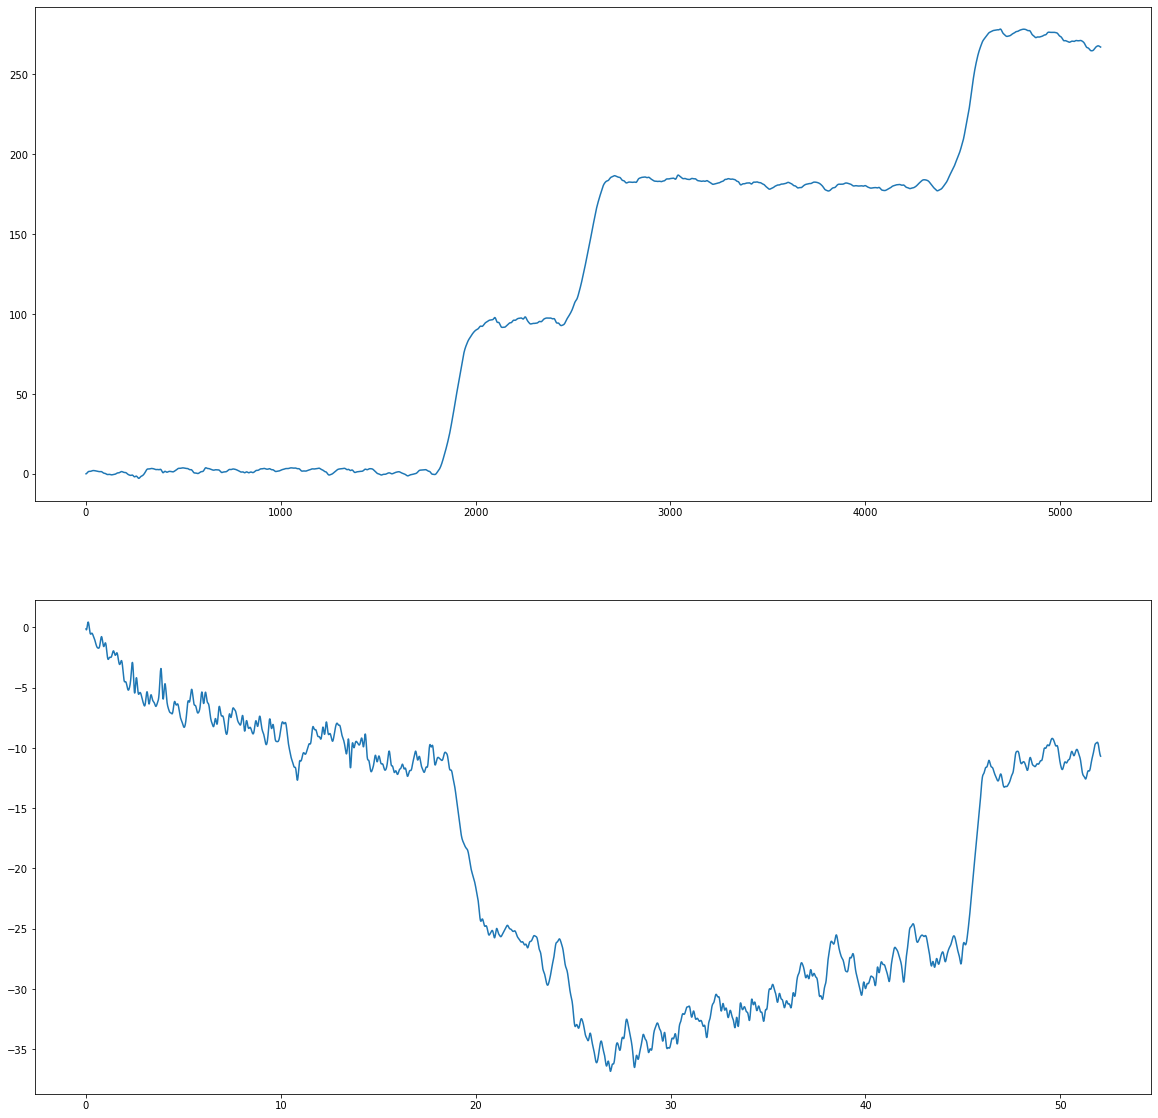

In [22]:
#########################################################################
########################## Madgwick Test ################################
#########################################################################
# import math
def Madgwick_heading(sample_period, quartenion, beta, mag_data, gyro_data, acc_data):
    heading = MadgwickAHRS(sample_period, quartenion, beta)
    ahrs = []
    roll, pitch, yaw = [], [], []
    roll_2, pitch_2, yaw_2 = [], [], []

    for index, data in enumerate(mag_data):
        heading.update(gyro_data[index], acc_data[index], mag_data[index])
        ahr = heading.quaternion.to_euler_angles()
        ahr_2 = heading.quaternion.to_euler123()
        roll_2.append(ahr_2[0])
        pitch_2.append(ahr_2[1])
        yaw_2.append(ahr_2[2])
        ahrs.append([ahr[0], ahr[1], ahr[2]])
        roll.append(ahr[0])
        pitch.append(ahr[1])
        yaw.append(ahr[2])

    return ahrs, roll, pitch, yaw, roll_2, pitch_2, yaw_2

########################################################################################################
def yaw_normalization(yaw_deg):
#     new_deg = yaw_deg % 360
    new_deg = (yaw_deg + 360) % 360
    # for index, yaw in enumerate(new_deg):
    #     if yaw > 180:
    #         new_deg[index] = yaw - 360
    return new_deg
########################################################################################################
def yaw_normalization_2(yaw_deg):
    for index, yaw in enumerate(yaw_deg):
        if index == 0:
            continue
        else:
            if yaw > 0 > yaw_deg[index - 1] and abs(yaw_deg[index-1]) > 170:
                yaw_deg[index] = yaw_deg[index] - 360
            if yaw < 0 < yaw_deg[index - 1] and abs(yaw_deg[index-1]) > 170:
                yaw_deg[index] = yaw_deg[index] + 360
########################################################################################################
# Set up parameters
sample_period = 1 / 100
quartenion = Quaternion(1, 0, 0, 0)
beta = 0.001

#Create data
gyro_data, acc_data = create_data(lp_gyro_x, lp_gyro_y, lp_gyro_z), create_data(lp_acc_x, lp_acc_y, lp_acc_z)
mag_data = create_data(iron_compensated_x, iron_compensated_y, iron_compensated_z)
# mag_data = create_data(lp_mag_x, lp_mag_y, lp_mag_z)

#Angle evaluation
_, roll, pitch, yaw, roll_2, pitch_2, yaw_2 = Madgwick_heading(sample_period, quartenion, beta, mag_data, gyro_data, acc_data)
# print(yaw)
#########################################################################################################
#Convert to numpy array and from radian to degree
yaw = np.array(yaw)
pitch = np.array(pitch)
roll = np.array(roll)
yaw_deg = yaw * (180 / np.pi)
pitch_deg = pitch * (180 / np.pi)
roll_deg = roll * (180 / np.pi)
# fig, axs = plt.subplots(1, 3)

roll_2 = np.array(roll_2)
pitch_2 = np.array(pitch_2)
yaw_2 = np.array(yaw_2)
yaw_deg_2 = yaw_2 * (180 / np.pi)
pitch_deg_2 = pitch_2 * (180 / np.pi)
roll_deg_2 = roll_2 * (180 / np.pi)
###############################################################
#Plot data

plt.rcParams['figure.figsize'] = 20, 20
fig, axs = plt.subplots(2, 1)
# axs[0].plot(roll_deg_2)
# axs[0].set_title('roll')
# axs[1].plot(pitch_deg_2)
# axs[1].set_title('pitch')
# axs[2].plot(mag_t, yaw_deg_2)
# axs[2].set_title('yaw')
# plt.show()
# yaw_deg_2 = yaw_deg_2 + iron_compensated_angles[0]
yaw_normalization_2(yaw_deg_2)

axs[0].plot(yaw_deg_2)
axs[1].plot(gyro_t, roll_deg_2)

print(sum(np.absolute(yaw_deg_2))/len(yaw_deg_2))

# error = yaw_deg_2 - yaw_deg_2[0]


In [ ]:
plt.figure(figsize=(10,40))
plt.subplot(4,1,1)
plt.plot(mag_t[:2000],yaw_deg_2[:2000])
plt.subplot(4,1,2)
plt.plot(mag_t[2000:4000],yaw_deg_2[2000:4000])
plt.subplot(4,1,3)
plt.plot(mag_t[4000:6000],yaw_deg_2[4000:6000])
plt.subplot(4,1,4)
plt.plot(mag_t[6000:],yaw_deg_2[6000:])

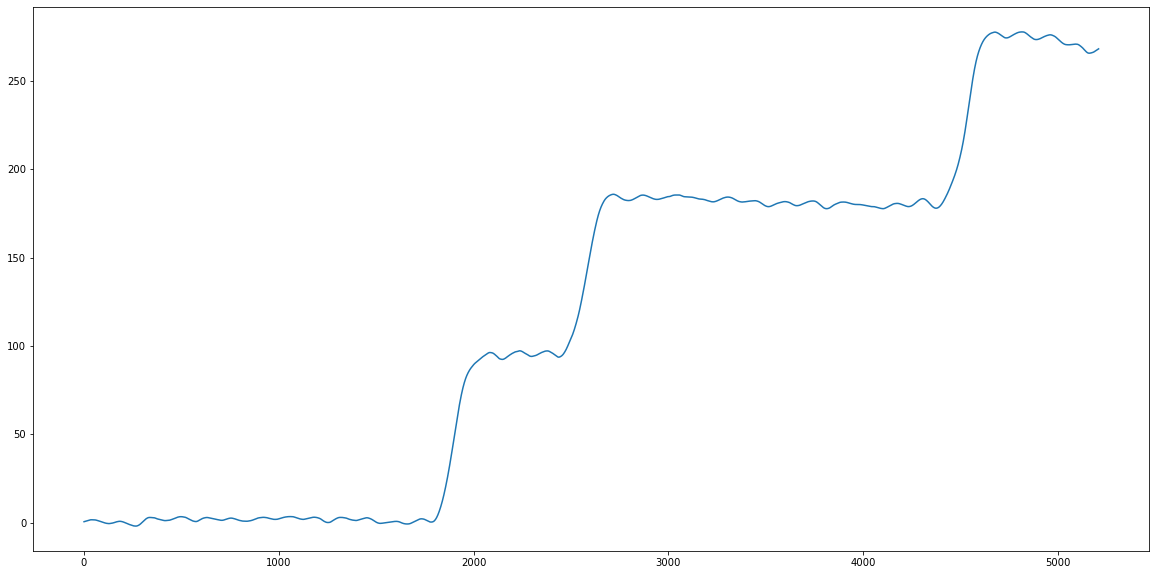

In [24]:
#Post processing
from scipy.signal import savgol_filter


def Savitzky_filter(yaw_deg):
    new_deg = savgol_filter(yaw_deg, 51, 1)
    return new_deg

def detect_jump(yaw_deg):
    new_deg = []
    indexes = []
    start = 0
    for index, yaw in enumerate(yaw_deg):
        if index + 1 > len(yaw_deg) -1:
            break
        if abs(yaw_deg[index] - yaw_deg[index + 1]) > 350:
            indexes.append(index)
            # start = index + 1

    for index in indexes:
        new_deg.append(yaw_deg[start:index + 1])
        start = index + 1
        # new_deg.append(yaw_deg[index[0]: index[1]])
    new_deg.append(yaw_deg[start:])

    return indexes, new_deg

def filter_and_join(yaw_deg_lst):
    new_yaw, combine_yaw = [], []
    for index, yaw in enumerate(yaw_deg_lst):
        new_yaw.append(Savitzky_filter(yaw))

    for yaw in new_yaw:
        yaw = np.array(yaw).tolist()
        combine_yaw = combine_yaw + yaw

    return combine_yaw

plt.rcParams['figure.figsize'] = 20, 10
# jump_index, yaw_deg_lst = detect_jump(yaw_deg_2)
# combined_yaw =filter_and_join(yaw_deg_lst)
# plt.plot(combined_yaw)
# print(sum(np.absolute(combined_yaw))/len(combined_yaw))
filtered_yaw = Savitzky_filter(yaw_deg_2)
plt.plot(filtered_yaw)
        

In [ ]:
# plt.figure(figsize=(10,40))
# plt.subplot(4,1,1)
# plt.plot(mag_t[:2000],filtered_data[:2000])
# plt.subplot(4,1,2)
# plt.plot(mag_t[2000:4000],filtered_data[2000:4000])
# plt.subplot(4,1,3)
# plt.plot(mag_t[4000:6000],filtered_data[4000:6000])
# plt.subplot(4,1,4)
# plt.plot(mag_t[6000:],filtered_data[6000:])

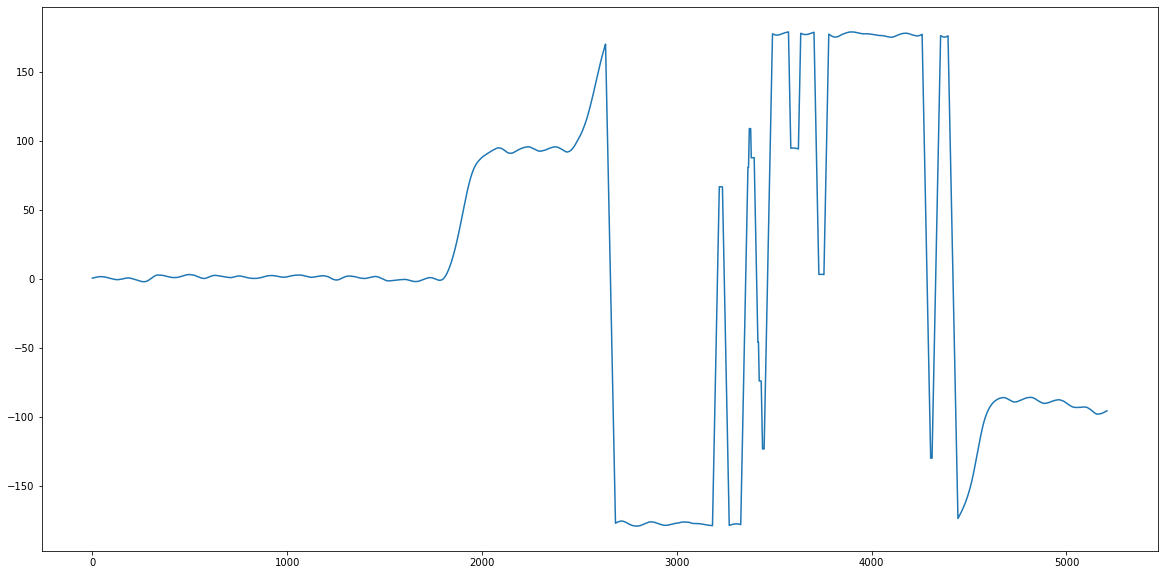

In [10]:
new_yaw = Savitzky_filter(yaw_deg_2)
plt.plot(new_yaw)